<a href="https://colab.research.google.com/github/Far0311/Data-Analysis-with-Phyton/blob/main/Anomaly_Detection_in_Bank_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [75]:
# Load the dataset
file_path = "/content/bank_transactions_data_2.csv"
df = pd.read_csv(file_path)

In [76]:
# View the first 5 rows of the dataframe
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [77]:
# Select the relevant numerical features for anomaly detection
features = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
df_selected = df[features]

In [78]:
# Scale the features
# Feature scaling is necessary for anomaly detection because many anomaly detection algorithms, including k-Nearest Neighbors (k-NN) and Isolation Forest, perform better when the numerical features are on a similar scale
# Scaling is crucial for k-NN to ensure fair distance measurement.
# Isolation Forest can work without scaling, but scaling improves consistency.
# It prevents one feature from dominating over others in distance-based methods.
# Improves visualization and interpretability of resultsscaler = StandardScaler()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']])

#convert scaled data back into a dataframe
df_scaled = pd.DataFrame(df_scaled, columns=['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance'])

# 1. Using Isolation Forest for Anomaly Detection

In [79]:
# iso_forest = IsolationForest(contamination = "auto", random_state = 42) # A value of auto to force the model to self-detect anomalies
iso_forest = IsolationForest(contamination = 0.02, random_state = 42) # A value of 0.02 means 2% of the data is assumed to be anomalous
df['Anomaly_IF'] = iso_forest.fit_predict(df_scaled)

In [80]:
# Anomalies detected by Isolation FOrest (-1 means anomaly)
df_anomalies_if = df[df['Anomaly_IF'] == -1]

In [81]:
print(df['Anomaly_IF'].value_counts(normalize=True))  # Shows percentage of anomalies


Anomaly_IF
 1    0.979697
-1    0.020303
Name: proportion, dtype: float64


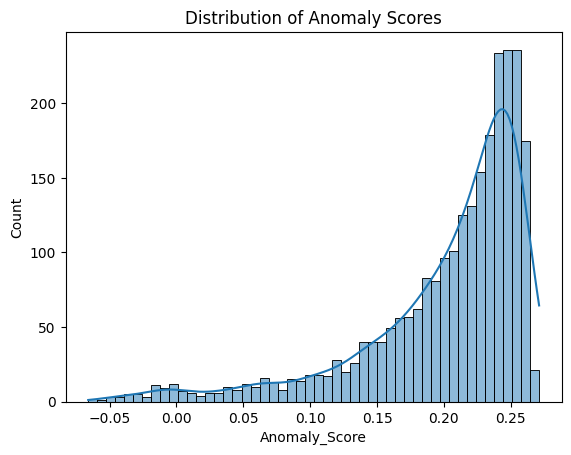

In [82]:
# Checking isolation score
df['Anomaly_Score'] = iso_forest.decision_function(df_scaled)  # Scores for anomalies
sns.histplot(df['Anomaly_Score'], bins=50, kde=True)
plt.title("Distribution of Anomaly Scores")
plt.show()


# 2. Using k-Nearrest Neighbours (k-NN) for Anomaly Detection

In [83]:
knn = NearestNeighbors(n_neighbors = 5)
knn.fit(df_scaled)

NearestNeighbors()

In [84]:
# Compute distances to k nearest neighbours
distances, _ = knn.kneighbors(df_scaled)
df['Anomaly_Score_kNN'] = distances[:, -1] # Use distance to the farthest neighbor
threshold = np.percentile(df['Anomaly_Score_kNN'], 98) # Top 2% are anomalies
df['Anomaly_kNN'] = df ['Anomaly_Score_kNN'] > threshold

df_anomalies_knn = df[df['Anomaly_kNN'] == True]

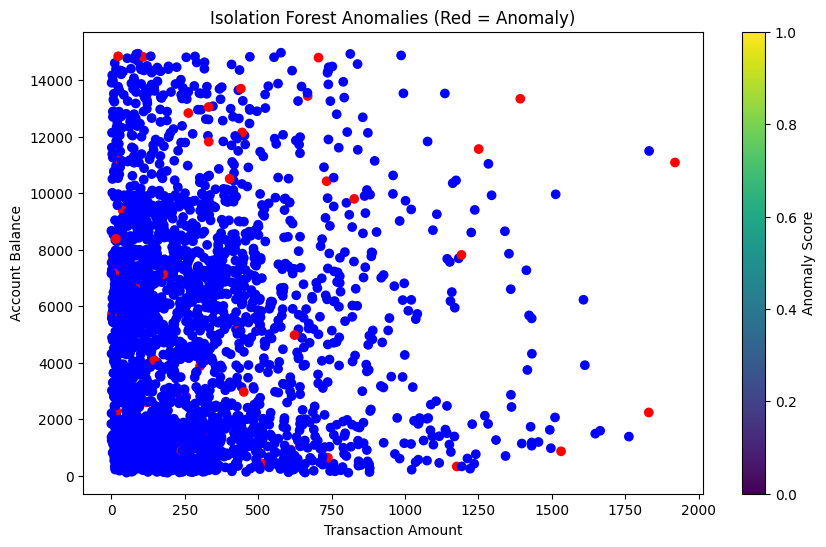

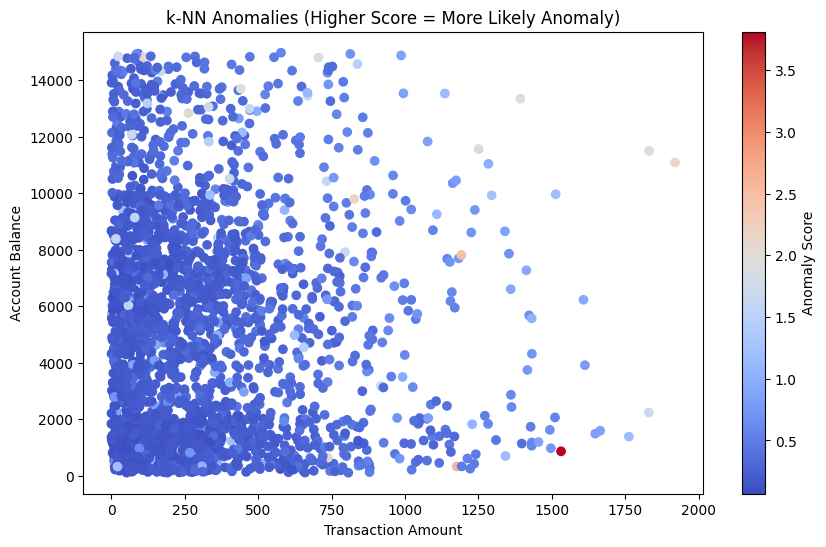

In [85]:
# Visualization of anomalies
plt.figure(figsize = (10, 6))
plt.scatter(df['TransactionAmount'], df['AccountBalance'], c=df['Anomaly_IF'].map({1: 'blue', -1: 'red'}))
plt.title("Isolation Forest Anomalies (Red = Anomaly)")
plt.xlabel("Transaction Amount")
plt.ylabel("Account Balance")
plt.colorbar(label = "Anomaly Score")
plt.show()

plt.figure(figsize = (10, 6))
plt.scatter(df['TransactionAmount'], df['AccountBalance'], c = df['Anomaly_Score_kNN'], cmap = 'coolwarm')
plt.title("k-NN Anomalies (Higher Score = More Likely Anomaly)")
plt.xlabel("Transaction Amount")
plt.ylabel("Account Balance")
plt.colorbar(label = "Anomaly Score")
plt.show()

In [86]:
# Save anomalies to CSV for review
df_anomalies_if.to_csv('Detected_Anomalies_IsolationForest.csv', index = False)
df_anomalies_knn.to_csv('Detected_Anomalies_kNN.csv', index = False)

In [87]:
# Display anomalies in Colab
from IPython.display import display
print("Anomalies detected by Isolation Forest:")
display(df_anomalies_if.head())

Anomalies detected by Isolation Forest:


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,Anomaly_IF
26,TX000027,AC00441,246.93,2023-04-17 16:37:01,Debit,Miami,D000046,55.154.161.250,M029,ATM,23,Student,158,5,673.35,2024-11-04 08:11:38,-1
147,TX000148,AC00161,514.95,2023-04-13 18:37:48,Debit,New York,D000109,23.92.205.75,M056,Online,41,Doctor,142,5,421.93,2024-11-04 08:10:01,-1
231,TX000232,AC00430,705.60,2023-02-20 18:41:43,Debit,Phoenix,D000103,205.45.234.42,M071,Branch,40,Doctor,124,3,14804.70,2024-11-04 08:09:04,-1
274,TX000275,AC00454,1176.28,2023-12-20 16:08:02,Credit,Kansas City,D000476,50.202.8.53,M074,ATM,54,Engineer,174,5,323.69,2024-11-04 08:11:44,-1
340,TX000341,AC00107,1830.00,2023-03-01 16:31:58,Debit,San Antonio,D000436,62.27.235.199,M082,Online,55,Engineer,238,1,2235.70,2024-11-04 08:11:59,-1


In [88]:
print("Anomalies detected by k-NN:")
display(df_anomalies_knn.head())

Anomalies detected by k-NN:


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,Anomaly_IF,Anomaly_Score,Anomaly_Score_kNN,Anomaly_kNN
38,TX000039,AC00478,795.31,2023-10-12 17:07:40,Debit,Mesa,D000077,49.29.37.185,M048,ATM,66,Doctor,90,2,7914.88,2024-11-04 08:11:17,1,0.084798,1.678040,True
61,TX000062,AC00002,263.99,2023-05-16 16:07:30,Debit,Dallas,D000285,7.146.35.122,M087,Branch,79,Retired,227,2,4175.02,2024-11-04 08:11:03,1,0.081057,1.446427,True
117,TX000118,AC00498,56.98,2024-01-01 16:34:10,Credit,Oklahoma City,D000256,101.90.40.193,M086,ATM,43,Engineer,122,2,5688.37,2024-11-04 08:07:42,1,0.121051,1.353406,True
231,TX000232,AC00430,705.60,2023-02-20 18:41:43,Debit,Phoenix,D000103,205.45.234.42,M071,Branch,40,Doctor,124,3,14804.70,2024-11-04 08:09:04,-1,-0.003414,1.901799,True
274,TX000275,AC00454,1176.28,2023-12-20 16:08:02,Credit,Kansas City,D000476,50.202.8.53,M074,ATM,54,Engineer,174,5,323.69,2024-11-04 08:11:44,-1,-0.047158,2.576824,True
